In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyfonts import load_font

## Get data

In [2]:
df = pd.read_csv("data//activities.csv")

In [3]:
#dataset checks ----------------------
columns = df.columns
expected_columns = ['Activity ID', 'Activity Date', 'Activity Name', 'Activity Type', 'Distance', 'Moving Time']
missing_columns = []
flag = False

for column in expected_columns:
    if column not in columns:
        flag=True
        missing_columns.append(column)

if flag==True:
    print("Your dataset looks off")
    print("----")
    print("The dataset is missing the following columns: " + str(missing_columns))
    print("Check that the dataset matches the expected format outlined here")

In [4]:
#reduce to relevant columns
df = df[expected_columns]

#convert date column into datetime
df["Activity Date"] = pd.to_datetime(df["Activity Date"])

## Analyse and prepare data

In [5]:
#inputs -----------------------

#set filter
year_filter = 2024

#set aggregation method
agg_method = "Counts"

#data prep -----------------------

#filter for 1 year
df_filtered = df[df["Activity Date"].dt.year == year_filter]

#get max top 3 activity types for aggregation method
if agg_method in ["Moving time", "Distance"]:
    top_three = df_filtered.groupby(["Activity Type"]
                                    )[agg_method].sum().sort_values(
                                    ascending=False).head(3).index.to_list()
else:
    top_three = df_filtered["Activity Type"].value_counts().head(3).index.to_list()

#derive clean column for activity types to use later
df_filtered["Activity Type clean"] = [activity if activity in top_three else "Other"
                                        for activity in df_filtered['Activity Type']]

C:\Users\lisa.hornung\AppData\Local\Temp\ipykernel_14068\1636937949.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Activity Type clean"] = [activity if activity in top_three else "Other"


In [6]:
#pre-aggregate data
pivot = df_filtered.groupby([df_filtered["Activity Date"].dt.month,
                             df_filtered["Activity Date"].dt.day]).agg({'Activity Type clean': ','.join})
pivot.index.names = ["Month", "Day"]
pivot = pivot.reset_index()
pivot["Activity Type clean"] = [i.split(",") for i in pivot["Activity Type clean"]]
pivot.head()

,Month,Day,Activity Type clean
0,1,2,[Yoga]
1,1,3,"[Ride, Ride]"
2,1,9,[Weight Training]
3,1,11,[Weight Training]
4,1,16,"[Ride, Ride]"


## Visualise

In [67]:
#config -----------------------

#create colour dict for activities
act_color = ["#6DB4C8", "#FD7B5C", "#F1C150", "#B8B8B8"]
act_colormap = dict(zip(top_three + ["Other"], act_color))

#colors
colors = {"bg": "#FBF9F5"}

#basesize of circles
markersize = 80

#axis labels
month_labels = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']

#fonts
font_b = load_font(font_url='https://github.com/andrew-paglinawan/QuicksandFamily/blob/master/fonts/statics/Quicksand-Bold.ttf?raw=true')
font_r = load_font(font_url='https://github.com/andrew-paglinawan/QuicksandFamily/blob/master/fonts/statics/Quicksand-Regular.ttf?raw=true')
font_m = load_font(font_url='https://github.com/andrew-paglinawan/QuicksandFamily/blob/master/fonts/statics/Quicksand-Medium.ttf?raw=true')
font_handwritten = load_font(font_url='https://github.com/google/fonts/blob/main/apache/rocksalt/RockSalt-Regular.ttf?raw=true')

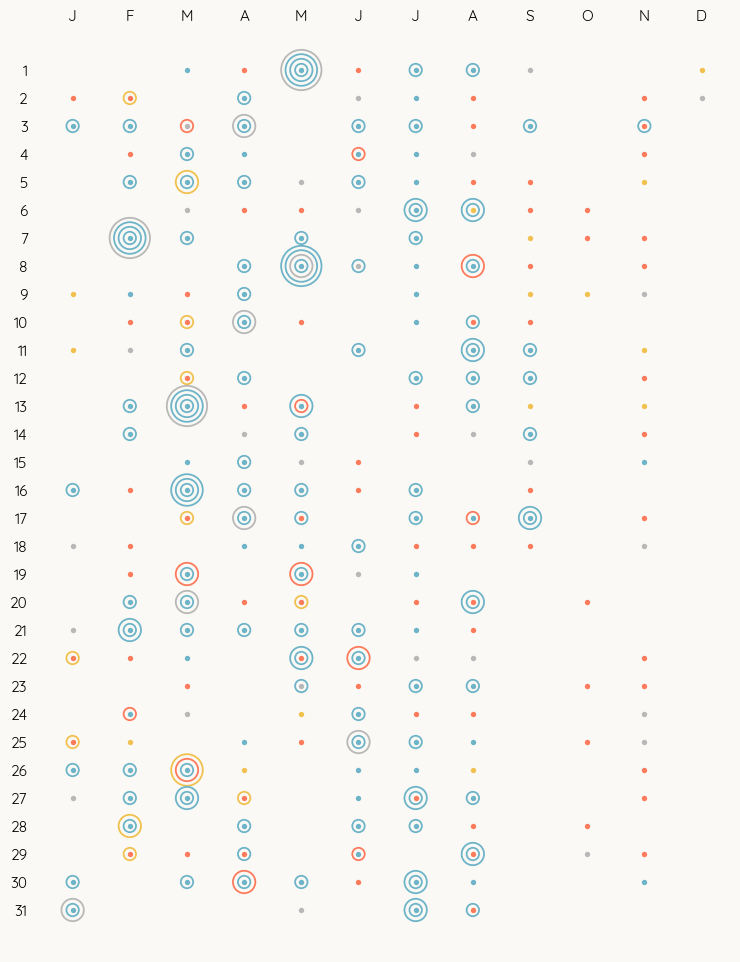

In [97]:
#setup fig-------------------------------

fig, ax = plt.subplots(figsize=(9,12))
fig.set_facecolor(colors["bg"])
ax.set_facecolor(colors["bg"])

#plot data -----------
for row in range(len(pivot)):
    for i,label in enumerate(pivot.loc[row]["Activity Type clean"]):
        if i==0:
            ax.scatter(x=pivot.loc[row]["Month"],
                  y=pivot.loc[row]["Day"],
                  s=15,
                  linewidth=0,
                  color=act_colormap[label])
        else:
            ax.scatter(x=pivot.loc[row]["Month"],
                  y=pivot.loc[row]["Day"],
                  s=(i**1.7)*markersize,
                  color="None",
                  edgecolor=act_colormap[label],
                  linewidth=1.3)
            
#format axis------------------
ax.invert_yaxis()
ax.set_xticks(np.arange(1,13,1))
ax.set_yticks(np.arange(1,32,1))
ax.tick_params(axis="both", length=0, labeltop=True, labelbottom=False,)
ax.set_yticklabels(labels=ax.get_yticks(), fontproperties=font_r, fontsize=11)
ax.set_xticklabels(labels=month_labels, fontproperties=font_r, fontsize=11)
ax.set_xlim(xmin=0.3,xmax=12.5)
for pos in ["top", "bottom", "left", "right"]:
    ax.spines[pos].set_visible(False)
#ax.axis("off")
#plt.show()

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd S

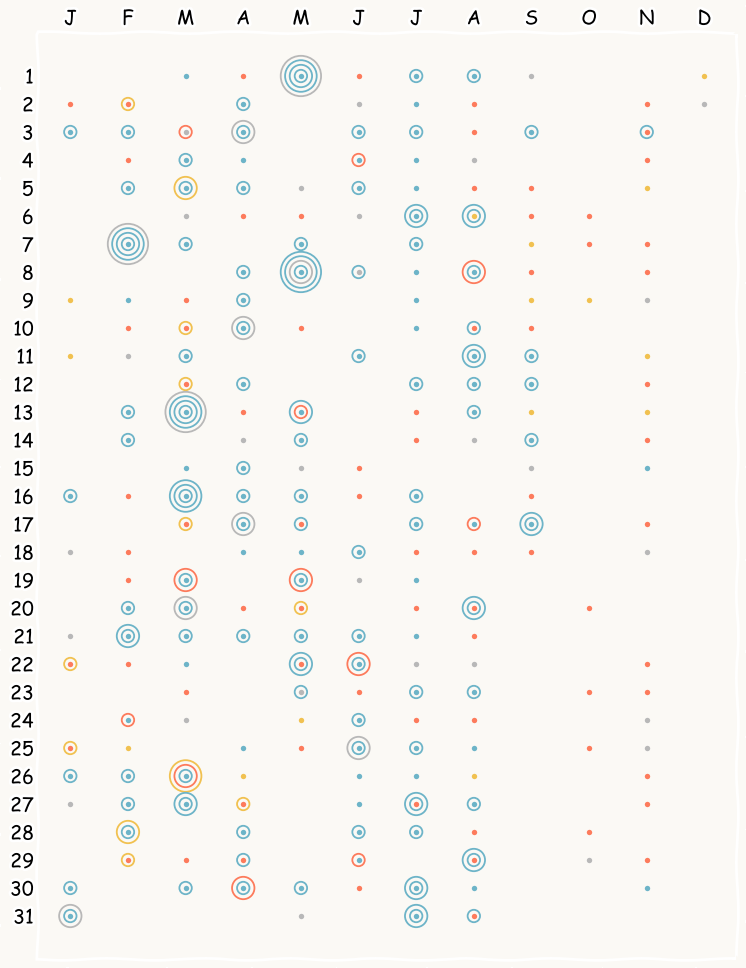

In [36]:
#setup fig-------------------------------
with plt.xkcd():
    fig, ax = plt.subplots(figsize=(9,12))
    fig.set_facecolor(colors["bg"])
    ax.set_facecolor(colors["bg"])

    #plot data -----------
    for row in range(len(pivot)):
        for i,label in enumerate(pivot.loc[row]["Activity Type clean"]):
            if i==0:
                ax.scatter(x=pivot.loc[row]["Month"],
                    y=pivot.loc[row]["Day"],
                    s=15,
                    linewidth=0,
                    color=act_colormap[label])
            else:
                ax.scatter(x=pivot.loc[row]["Month"],
                    y=pivot.loc[row]["Day"],
                    s=(i**1.7)*markersize,
                    color="None",
                    edgecolor=act_colormap[label],
                    linewidth=1.3)
            
#format axis------------------

    ax.invert_yaxis()
    ax.set_xticks(np.arange(1,13,1), month_labels)
    ax.xaxis.set_tick_params(labeltop=True, labelbottom=False, length=0)
    ax.set_yticks(np.arange(1,32,1))
    ax.yaxis.set_tick_params(length=0)
    for pos in ["top", "bottom", "left", "right"]:
        ax.spines[pos].set_visible(False)
#ax.axis("off")
    plt.show()

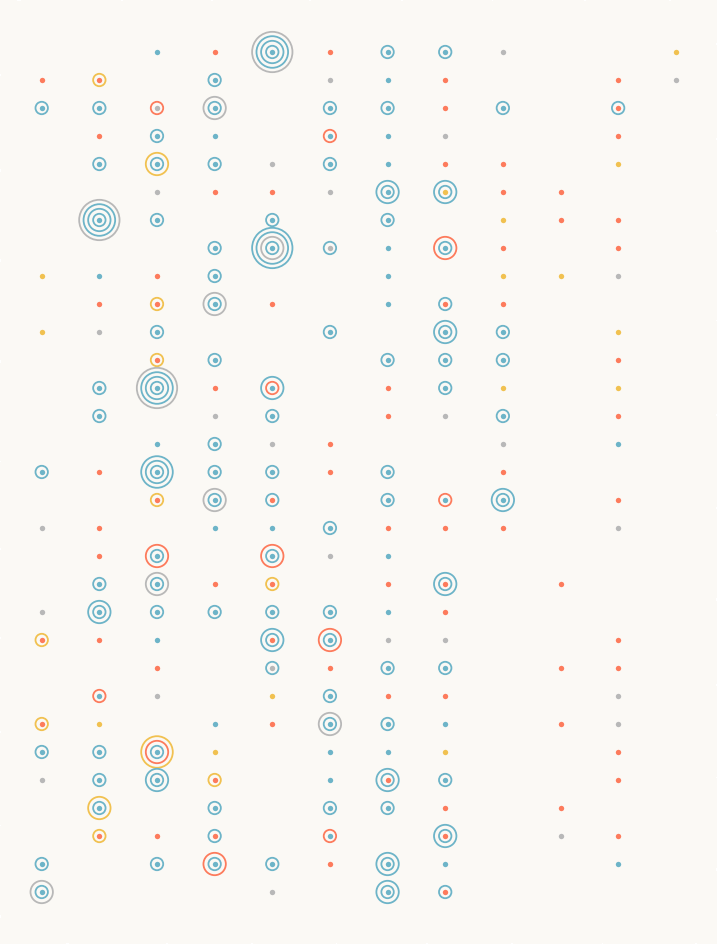

In [240]:
#setup fig-------------------------------

fig, ax = plt.subplots(figsize=(9,12))
fig.set_facecolor(colors["bg"])
ax.set_facecolor(colors["bg"])

#plot data -----------
with plt.xkcd(scale=5,length=200, randomness=5):
    for row in range(len(pivot)):
        for i,label in enumerate(pivot.loc[row]["Activity Type clean"]):
            if i==0:
                ax.scatter(x=pivot.loc[row]["Month"],
                  y=pivot.loc[row]["Day"],
                  s=15,
                  linewidth=0,
                  color=act_colormap[label])
            else:
                ax.scatter(x=pivot.loc[row]["Month"],
                  y=pivot.loc[row]["Day"],
                  s=(i**1.7)*markersize,
                  color="None",
                  edgecolor=act_colormap[label],
                  linewidth=1.3)
            
#format axis------------------
ax.invert_yaxis()
ax.axis("off")
plt.show()

In [ ]:
res = ast.literal_eval(ini_list)